## Data reading and manipulation

In [82]:
# activate the environment
using Pkg
Pkg.activate("/home/enes/avg/WoR/world_on_rails.jl")

  Activating environment at `~/avg/WoR/world_on_rails.jl/Project.toml`


In [85]:
using YAML: load_file
using Images
using Images.FileIO
using Images.Colors
using StrLiterals
using LMDB
using LMDB: create, open, close, put!, start

In [86]:
DATA_ROOT = "/home/enes/avg/WoR/dataset"
CONFIG_PATH = "/home/enes/avg/WoR/world_on_rails.jl/configs/config.yaml"

"/home/enes/avg/WoR/world_on_rails.jl/configs/config.yaml"

In [87]:
struct MainDataset
    config::Dict
    num_frames::Int
    txn_map::Dict
    dbi_map::Dict
    idx_map::Dict
    yaw_map::Dict
    file_map::Dict

    function MainDataset(data_dir::AbstractString, config_path::AbstractString)
        # read the config file
        num_frames = 0
        config = load_file(config_path)
        txn_map = Dict()
        dbi_map = Dict()
        idx_map = Dict()
        yaw_map = Dict()
        file_map = Dict()
        
        for full_path in readdir(data_dir, join=true)
            if !isdir(full_path)
                continue
            end
            env = create()
            open(env, full_path)
            txn = start(env)

            dbi = open(txn)
            
            n = parse(Int64, LMDB.get(txn, dbi, "len", String))
            if n < config["num_plan"]+1
                print(full_path, " is too small. consider deleting")
                close(env, dbi)
            else
                offset = num_frames
                for i in 0:n-config["num_plan"]-1
                    num_frames+=1
                    for j in 0:length(config["camera_yaws"])-1
                        txn_map[(offset+i)*length(config["camera_yaws"])+j] = txn
                        dbi_map[(offset+i)*length(config["camera_yaws"])+j] = dbi
                        idx_map[(offset+i)*length(config["camera_yaws"])+j] = i
                        yaw_map[(offset+i)*length(config["camera_yaws"])+j] = j
                        file_map[(offset+i)*length(config["camera_yaws"])+j] = full_path
                    end
                end
            end
        end
        print(data_dir,": ", num_frames, " frames ", "x ", length(config["camera_yaws"]))
        new(config, num_frames, txn_map, dbi_map, idx_map, yaw_map, file_map)
    end
end

In [88]:
function access(d::MainDataset, tag::AbstractString, txn::Transaction, dbi::DBI, index::Int, T::Int, dtype::Type; preprocess = x->x)
    try
        data = preprocess.([LMDB.get(txn, dbi, "$(tag)_$(lpad(t, 5, '0'))", dtype) for t in index:index+(T-1)])
        reduce(hcat, data)
    catch
        @show tag
    end
end

access (generic function with 1 method)

In [90]:
main_dataset = MainDataset(DATA_ROOT, CONFIG_PATH)

/home/enes/avg/WoR/dataset: 1932 frames x 3

MainDataset(Dict{Any, Any}("ego_model_dir" => "/kuacc/users/merciyes18/WorldOnRails/ego_model.th", "num_plan" => 5, "camera_yaws" => [0, -30, 30], "multi_cam" => true, "num_orient" => 5, "num_throts" => 3, "all_speeds" => true, "temperature" => 0.01, "ego_data_dir" => ["PATH TO PHASE 0 DATA"], "min_speeds" => 0.0…), 1932, Dict{Any, Any}(4986 => Transaction(Ptr{Nothing} @0x0000000008954d00), 4700 => Transaction(Ptr{Nothing} @0x000000000886fa50), 4576 => Transaction(Ptr{Nothing} @0x000000000886fa50), 2288 => Transaction(Ptr{Nothing} @0x0000000008d4eef0), 1703 => Transaction(Ptr{Nothing} @0x0000000008b6e780), 1956 => Transaction(Ptr{Nothing} @0x0000000008d4eef0), 2350 => Transaction(Ptr{Nothing} @0x0000000008ba8080), 3406 => Transaction(Ptr{Nothing} @0x00000000090e4f80), 2841 => Transaction(Ptr{Nothing} @0x0000000008ba8080), 2876 => Transaction(Ptr{Nothing} @0x0000000008ba8080)…), Dict{Any, Any}(4986 => DBI(0x00000001, ""), 4700 => DBI(0x00000001, ""), 4576 => DBI(0x00000001, ""), 2288 =>

In [91]:
Base.length(d::MainDataset) = (if (d.config["multi_cam"]) d.num_frames*length(d.config["camera_yaws"]) else d.num_frames end)

In [92]:
length(main_dataset)

5796

In [136]:
function get_item(d::MainDataset, state::Int)
    T = d.config["num_plan"]
    idx = state -1
    if !d.config["multi_cam"]
        idx *= length(d.config["camera_yaws"])
    end
    
    lmdb_txn = d.txn_map[idx]
    lmdb_dbi = d.dbi_map[idx]
    index = d.idx_map[idx]
    cam_index = d.yaw_map[idx]

    locs = access(d, "loc", lmdb_txn, lmdb_dbi, index, T+1, Vector{Float32})
    rots = access(d, "rot", lmdb_txn, lmdb_dbi, index, T, Vector{Float32})
    spds = access(d, "spd", lmdb_txn, lmdb_dbi, index, T, Vector{Float32})
    
    decode = (x -> FileIO.load(IOBuffer(x)))
    lbls = [access(d, "lbl_$(lpad(l, 2, '0'))", lmdb_txn, lmdb_dbi, index+1, T, Vector{UInt8}; preprocess=decode) |> channelview for l in 0:11]
    wide_rgb = access(d, "wide_$(cam_index)", lmdb_txn, lmdb_dbi, index, 1, Vector{UInt8}; preprocess=decode) |> channelview
    wide_sem = access(d, "wide_sem_$(cam_index)", lmdb_txn, lmdb_dbi, index, 1, Vector{UInt8}; preprocess=decode) |> channelview
    narr_rgb = access(d, "narr_$(cam_index)", lmdb_txn, lmdb_dbi, index, 1, Vector{UInt8}; preprocess=decode) |> channelview
    
    cmd = access(d, "cmd", lmdb_txn, lmdb_dbi, index, 1, Vector{Float32})
    wide_rgb, wide_sem, narr_rgb, lbls, locs, rots, spds, cmd
end

get_item (generic function with 1 method)

In [137]:
Base.iterate(d::MainDataset, state=1) = state > length(d) ? nothing : get_item(d, state), state+1 

  0.010502 seconds (3.66 k allocations: 5.157 MiB)


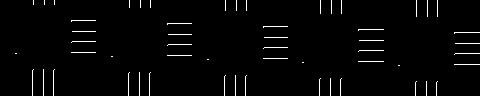

In [155]:
@time A = colorview(Gray, get_item(main_dataset, 1)[4][2] |> channelview)

### Convert Image to ChannelView

In [139]:
@time image = get_item(main_dataset, 1)[1]

  0.010849 seconds (3.66 k allocations: 5.157 MiB)


3×240×480 reinterpret(reshape, N0f8, ::Array{RGB{N0f8},2}) with eltype N0f8:
[:, :, 1] =
 0.537  0.537  0.537  0.537  0.537  …  0.573  0.573  0.576  0.576  0.576
 0.486  0.486  0.486  0.486  0.486     0.569  0.569  0.573  0.573  0.573
 0.451  0.451  0.451  0.451  0.451     0.588  0.588  0.592  0.592  0.592

[:, :, 2] =
 0.537  0.537  0.537  0.537  0.537  …  0.573  0.573  0.576  0.576  0.576
 0.486  0.486  0.486  0.486  0.486     0.569  0.569  0.573  0.573  0.573
 0.451  0.451  0.451  0.451  0.451     0.588  0.588  0.592  0.592  0.592

[:, :, 3] =
 0.541  0.541  0.541  0.541  0.541  …  0.573  0.576  0.576  0.576  0.576
 0.486  0.486  0.486  0.486  0.486     0.569  0.573  0.573  0.573  0.573
 0.443  0.443  0.443  0.443  0.443     0.588  0.592  0.592  0.592  0.592

...

[:, :, 478] =
 0.812  0.812  0.812  0.812  0.816  …  0.451  0.455  0.459  0.467  0.471
 0.675  0.675  0.675  0.675  0.678     0.455  0.459  0.463  0.471  0.475
 0.525  0.525  0.525  0.525  0.529     0.475  0.478  0.482  0.

In [111]:
image |> channelview

3×240×480 reinterpret(reshape, N0f8, ::Array{RGB{N0f8},2}) with eltype N0f8:
[:, :, 1] =
 0.537  0.537  0.537  0.537  0.537  …  0.573  0.573  0.576  0.576  0.576
 0.486  0.486  0.486  0.486  0.486     0.569  0.569  0.573  0.573  0.573
 0.451  0.451  0.451  0.451  0.451     0.588  0.588  0.592  0.592  0.592

[:, :, 2] =
 0.537  0.537  0.537  0.537  0.537  …  0.573  0.573  0.576  0.576  0.576
 0.486  0.486  0.486  0.486  0.486     0.569  0.569  0.573  0.573  0.573
 0.451  0.451  0.451  0.451  0.451     0.588  0.588  0.592  0.592  0.592

[:, :, 3] =
 0.541  0.541  0.541  0.541  0.541  …  0.573  0.576  0.576  0.576  0.576
 0.486  0.486  0.486  0.486  0.486     0.569  0.573  0.573  0.573  0.573
 0.443  0.443  0.443  0.443  0.443     0.588  0.592  0.592  0.592  0.592

...

[:, :, 478] =
 0.812  0.812  0.812  0.812  0.816  …  0.451  0.455  0.459  0.467  0.471
 0.675  0.675  0.675  0.675  0.678     0.455  0.459  0.463  0.471  0.475
 0.525  0.525  0.525  0.525  0.529     0.475  0.478  0.482  0.